In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [2]:
data = pd.read_csv('./ratings.csv')
books = pd.read_csv('./books.csv')

In [3]:
books = books[['id','book_id','authors','original_title','language_code','average_rating','image_url']]

In [4]:
books.head()

,id,book_id,authors,original_title,language_code,average_rating,image_url
0,1,2767052,Suzanne Collins,The Hunger Games,eng,4.34,https://images.gr-assets.com/books/1447303603m...
1,2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,eng,4.44,https://images.gr-assets.com/books/1474154022m...
2,3,41865,Stephenie Meyer,Twilight,en-US,3.57,https://images.gr-assets.com/books/1361039443m...
3,4,2657,Harper Lee,To Kill a Mockingbird,eng,4.25,https://images.gr-assets.com/books/1361975680m...
4,5,4671,F. Scott Fitzgerald,The Great Gatsby,eng,3.89,https://images.gr-assets.com/books/1490528560m...


In [5]:
data.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [6]:
data['book_id'] = data['book_id']-1
data['user_id'] = data['user_id']-1
books['id'] = books['id']-1

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

In [8]:
num_user = len(data['user_id'].unique())
num_book = len(data['book_id'].unique())

### Data preprocessing

In [9]:
# Create a sparse iteration matrix from rating data
def create_sparse_matrix(num_user,num_item,df):
    sess = tf.Session()
    indices = df[['user_id','book_id']].values.astype(np.int32)
    values = df['rating'].values.astype(np.int32)
    dense_shape = (num_user,num_item)
    resp =  sess.run(tf.SparseTensor(indices,values,dense_shape))
    tf.reset_default_graph()
    return resp

In [10]:
rating_matrix = create_sparse_matrix(num_user,num_book,data)

In [11]:
# create a class to generate data from sparse to dense format
class SparseToDenseGenerator:
    def __init__(self,sparse_matrix,num_row,num_col,batch_size=256):
        self.sess = tf.Session()
        self.sparse_matrix = sparse_matrix
        self.num_row = num_row
        self.num_col = num_col
        self.batch_size = batch_size
        self.total_batch = int(np.ceil(num_row/batch_size))
        self.count = 0
        
    def get(self):
        start = self.count*self.batch_size
        size = start+self.batch_size
        self.count+=1
        if (size > self.num_row):
            size = self.num_row
            self.count = 0
        with self.sess.graph.as_default():
            t = self.sess.run(tf.sparse.slice(self.sparse_matrix,[start,0],[size,self.num_col]))
            rep =  self.sess.run(tf.sparse.to_dense(t,validate_indices=False))  
        return rep.astype(np.float32)
    
class DataGenerator:
    def __init__(self,data,batch_size=256,shuffle=True):
        self.data = data
        self.row = data.shape[0]
        self.batch_size = batch_size
        self.total_batch = int(np.ceil(self.row/batch_size))
        self.count = 0
        self.shuffle=shuffle
        
    def get(self):
        done = False
        lower = self.count*self.batch_size
        upper = lower+self.batch_size
        self.count+=1
        if (upper > self.row):
            upper = self.row
            self.count = 0
            done = True
        resp = self.data[lower:upper]
        if done:
            perm = np.random.permutation(self.row)
            self.data = self.data[perm]
        return resp
        

In [12]:
dense_rating = tf.Session().run(tf.sparse.to_dense(rating_matrix,validate_indices=False))
data_generator = DataGenerator(dense_rating)

In [13]:
data_generator.total_batch

209

### AutoEncoder model

In [14]:
def forward_path(x):
    with tf.variable_scope('AutoEncoder',reuse=tf.AUTO_REUSE):
        z = tf.layers.Dense(512,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(x)
        z = tf.layers.Dense(512,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        latent = tf.layers.Dense(1024,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        latent = tf.layers.Dropout(0.8)(latent)
        z = z = tf.layers.Dense(512,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(latent)
        z = tf.layers.Dense(512,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        out = tf.layers.Dense(num_book,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        return out


In [15]:
tf.reset_default_graph()

In [16]:
x = tf.placeholder(dtype=tf.float32,shape=[None,num_book],name='data')
optimizer = tf.train.GradientDescentOptimizer(0.05)

# Forward path
out = forward_path(x)
loss = tf.math.sqrt(tf.losses.mean_squared_error(x,out))
train = optimizer.minimize(loss)

# Dense Re-feeding (DR)
dr_out = forward_path(out)
dr_loss = tf.math.sqrt(tf.losses.mean_squared_error(out,dr_out))
dr_train = optimizer.minimize(dr_loss)

W0719 10:30:18.523881 140410951362368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
model_session = tf.Session()
model_session.run(tf.global_variables_initializer())

In [18]:
trainable_variables = np.sum([np.prod(v.shape).value for v in tf.trainable_variables()])
print(f"Total trainable parameters = {trainable_variables}")

Total trainable parameters = 11825936


In [19]:
losses = []

In [20]:
EPOCHS = 200
for e in range(1,EPOCHS+1):
    avg_loss = []
    for i in range(data_generator.total_batch):
        with (model_session.graph.as_default()):
            batch_data = data_generator.get()
            loss_val, dr_loss_val, _, __= model_session.run([loss,dr_loss,train, dr_train],feed_dict={x:batch_data})
            
            avg_loss.append(loss_val)
            
            sys.stdout.write(f"\rEpoch {e}: loss (rmse) = {loss_val}")
            sys.stdout.flush()
    losses.append(np.mean(avg_loss))
    print(f"\rEpoch {e}: loss (rmse) = {np.mean(avg_loss)} (max = {np.max(avg_loss)}, min = {np.min(avg_loss)})")

Epoch 1: loss (rmse) = 0.26218414306640625 (max = 0.29356512427330017, min = 0.2235732525587082)
Epoch 2: loss (rmse) = 0.2488008290529251 (max = 0.2790862023830414, min = 0.2265963852405548)
Epoch 3: loss (rmse) = 0.2393394410610199 (max = 0.26217252016067505, min = 0.2149166315793991)
Epoch 4: loss (rmse) = 0.2314632385969162 (max = 0.25070711970329285, min = 0.20413115620613098)
Epoch 5: loss (rmse) = 0.22461473941802979 (max = 0.244609996676445, min = 0.1953752636909485)
Epoch 6: loss (rmse) = 0.21856386959552765 (max = 0.2413933277130127, min = 0.19667838513851166)
Epoch 7: loss (rmse) = 0.21306292712688446 (max = 0.2379947453737259, min = 0.18786115944385529)
Epoch 8: loss (rmse) = 0.20812082290649414 (max = 0.23758935928344727, min = 0.18826468288898468)
Epoch 9: loss (rmse) = 0.20369823276996613 (max = 0.2276735156774521, min = 0.18011987209320068)
Epoch 10: loss (rmse) = 0.19983771443367004 (max = 0.22200119495391846, min = 0.18294382095336914)
Epoch 11: loss (rmse) = 0.196398

Epoch 85: loss (rmse) = 0.17178507149219513 (max = 0.19514340162277222, min = 0.15417955815792084)
Epoch 86: loss (rmse) = 0.1717693954706192 (max = 0.1946393847465515, min = 0.15583570301532745)
Epoch 87: loss (rmse) = 0.17170381546020508 (max = 0.19111508131027222, min = 0.14627449214458466)
Epoch 88: loss (rmse) = 0.17171885073184967 (max = 0.19054381549358368, min = 0.1454555243253708)
Epoch 89: loss (rmse) = 0.17168378829956055 (max = 0.19191759824752808, min = 0.14933203160762787)
Epoch 90: loss (rmse) = 0.1716741919517517 (max = 0.1921084076166153, min = 0.14877726137638092)
Epoch 91: loss (rmse) = 0.17161451280117035 (max = 0.19556045532226562, min = 0.15360836684703827)
Epoch 92: loss (rmse) = 0.1715652048587799 (max = 0.20198319852352142, min = 0.1500920206308365)
Epoch 93: loss (rmse) = 0.17153006792068481 (max = 0.19458183646202087, min = 0.15243008732795715)
Epoch 94: loss (rmse) = 0.17157158255577087 (max = 0.19720488786697388, min = 0.14778564870357513)
Epoch 95: loss (r

Epoch 168: loss (rmse) = 0.17053036391735077 (max = 0.18999969959259033, min = 0.14532141387462616)
Epoch 169: loss (rmse) = 0.17048104107379913 (max = 0.19216614961624146, min = 0.14633731544017792)
Epoch 170: loss (rmse) = 0.17049619555473328 (max = 0.19564175605773926, min = 0.14998583495616913)
Epoch 171: loss (rmse) = 0.17050476372241974 (max = 0.19142000377178192, min = 0.15209145843982697)
Epoch 172: loss (rmse) = 0.17049112915992737 (max = 0.19530901312828064, min = 0.1517583578824997)
Epoch 173: loss (rmse) = 0.17050006985664368 (max = 0.1895822137594223, min = 0.14714545011520386)
Epoch 174: loss (rmse) = 0.17048349976539612 (max = 0.19108855724334717, min = 0.15167641639709473)
Epoch 175: loss (rmse) = 0.17045238614082336 (max = 0.18982213735580444, min = 0.1464499682188034)
Epoch 176: loss (rmse) = 0.17045629024505615 (max = 0.1928015649318695, min = 0.15407539904117584)
Epoch 177: loss (rmse) = 0.17045870423316956 (max = 0.19362476468086243, min = 0.14896506071090698)
Epoc

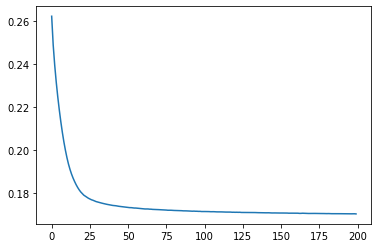

In [21]:
plt.plot(losses)

### Inference Model

In [22]:
from utils import user_items

In [24]:
target_user = 34
readed_books = user_items(data, target_user,'user_id','book_id')

In [25]:
t = np.expand_dims(dense_rating[target_user],axis=0)
pred = model_session.run(out,feed_dict={x:t})[0]

In [26]:
print("Books read by user:",target_user)
books[books['id'].isin(readed_books)].head()

Books read by user: 34


,id,book_id,authors,original_title,language_code,average_rating,image_url
77,77,5139,Lauren Weisberger,The Devil Wears Prada,eng,3.70,https://s.gr-assets.com/assets/nophoto/book/11...
107,107,9416,Sophie Kinsella,Confessions of a Shopaholic,eng,3.61,https://images.gr-assets.com/books/1327872404m...
119,119,452306,Ann Brashares,The Sisterhood of the Traveling Pants,eng,3.75,https://images.gr-assets.com/books/1461611233m...
134,134,62291,George R.R. Martin,A Storm of Swords,eng,4.54,https://images.gr-assets.com/books/1497931121m...
136,136,10964,Diana Gabaldon,Outlander,eng,4.20,https://images.gr-assets.com/books/1402600310m...


In [29]:
print("Books recommended to user:", target_user)
books[books['id'].isin(np.argsort(pred)[::-1][:20])].sample(5)

Books recommended to user: 34


,id,book_id,authors,original_title,language_code,average_rating,image_url
128,128,332613,Ken Kesey,One Flew Over the Cuckoo's Nest,eng,4.18,https://images.gr-assets.com/books/1485308778m...
827,827,9516,"Marjane Satrapi, Mattias Ripa",Persepolis,eng,4.23,https://images.gr-assets.com/books/1425871473m...
331,331,65605,C.S. Lewis,The magician's nephew,eng,4.01,https://images.gr-assets.com/books/1308814770m...
1416,1416,426775,Lauren Weisberger,Chasing Harry Winston,eng,3.32,https://s.gr-assets.com/assets/nophoto/book/11...
222,222,249747,Eoin Colfer,Artemis Fowl,eng,3.82,https://images.gr-assets.com/books/1327945104m...


### Evaluate Model

In [30]:
items_interact = data.groupby('book_id')['user_id'].agg({'count':'count'}).reset_index()
users_interact = data.groupby('user_id')['book_id'].agg({'count':'count'}).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


#### Histogram distribution of number of rating/book
We can see most book have the same number of rating (~100)

Text(0, 0.5, 'Number of book')

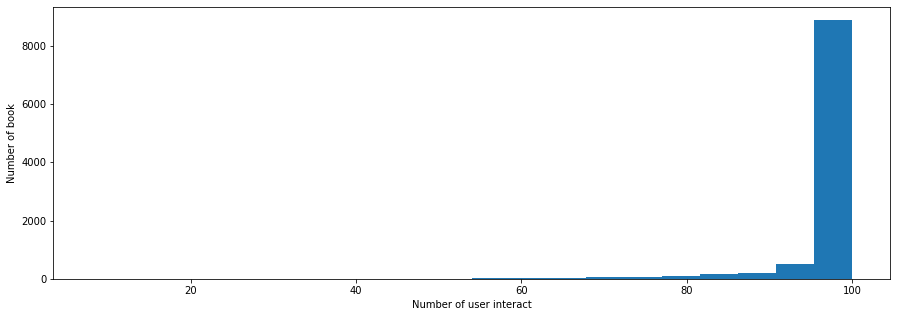

In [31]:
fig = plt.figure(figsize=[15,5])
_ = plt.hist(items_interact['count'],bins=20)
plt.xlabel('Number of user interact')
plt.ylabel('Number of book')

#### Histogram distribution of number of ratings given/user
We can see most people only read less than 15 books while very few read more than 50

Text(0, 0.5, 'Number of users')

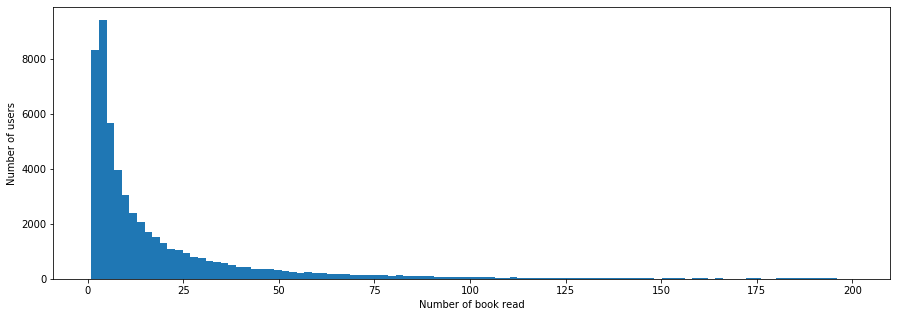

In [32]:
fig = plt.figure(figsize=[15,5])
_ = plt.hist(users_interact['count'],bins=100)
plt.xlabel('Number of book read')
plt.ylabel('Number of users')

#### Coverage of recommendation

In [33]:
k = 20
coverages = []
for i in range(num_user):
    t = np.expand_dims(dense_rating[i],axis=0)
    pred = model_session.run(out,feed_dict={x:t})[0]
    recom = np.argsort(pred)[::-1][:k]
    coverages += recom.tolist()
coverages = np.unique(coverages)
coverages = len(coverages)/num_book
print(f"The model cover {coverages*100}% of items in the dataset")

The model cover 93.78% of items in the dataset


#### Personalization of the recommendation

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
k = 20
coverages = []
for i in range(num_user):
    t = np.expand_dims(dense_rating[i],axis=0)
    pred = model_session.run(out,feed_dict={x:t})[0]
    recom = np.argsort(pred)[::-1][:k]
    coverages.append(recom)
coverages = np.array(coverages)

In [80]:
# Sample 1000 user to measure the similarity of their recommendation
# Calculate for 50k users is too much
SAMPLE_SIZE = 1000
sample = np.random.choice(num_user,size=SAMPLE_SIZE,replace=False)
t_coverages = coverages[sample]
t_matrix = np.zeros([SAMPLE_SIZE,num_book])
for i in range(SAMPLE_SIZE):
    t_matrix[i][t_coverages[i]]=1

similarity = cosine_similarity(t_matrix)
# Personalized Score = 1 - mean_of_upper_triangle(similarity)
# The higher the score, the better
personalized_score = 1-np.sum(np.triu(similarity))/(np.prod(similarity.shape)/2)
print("Personalization Score =",personalized_score)

Personalization Score = 0.9700389


#### Mean Average Precision & Mean Average Recall (MAP@K and MAR@K)
https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52

https://www.youtube.com/watch?v=pM6DJ0ZZee0

http://fastml.com/what-you-wanted-to-know-about-mean-average-precision/

In [81]:
# Sample 1000 user query
SAMPLE_SIZE = 1000
sample = np.random.choice(num_user,size=SAMPLE_SIZE,replace=False)
sample = dense_rating[sample]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)